# Cas d’étude : Classification de sentiments

In [83]:
import os
import re
import string
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, callbacks, layers, backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import binary_crossentropy

from sklearn.model_selection import train_test_split

from unicodedata import normalize
from collections import Counter

## Données

In [2]:
inputs, labels = pickle.load(open("data/sentiment_classif_data.p", "rb" ))
labels = labels.astype(int)

## Prétraitements
**Nombre de mots par entrées**  
A partir de l'information donnée la distribution du nombre de mots par entrée, on fixera la nombre de vocabulaire à 250 environ

## Prétraitements
### Nettoyage
- Dans la suite, on gardera les avis sans les découper par phrases.
- Les entités comme les nom de film ou de séries n'apportera pas d'information sur la simple tâche de classification des sentiments, donc le texte sera normalisé en minuscule.
- Les chiffres peuvent donner des informations sur la notations que donne les commentaires, donc elles seront gardées lors de la normalisation, malgré les différentes échelles de notations (/5, /10 et /20)
- Les ponctuation et les balises HTML seront supprimées

(array([1.244e+04, 7.895e+03, 2.659e+03, 1.086e+03, 5.260e+02, 3.060e+02,
        7.000e+01, 7.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00]),
 array([  10.,  174.,  338.,  502.,  666.,  830.,  994., 1158., 1322.,
        1486., 1650., 1814., 1978., 2142., 2306., 2470.]),
 <BarContainer object of 15 artists>)

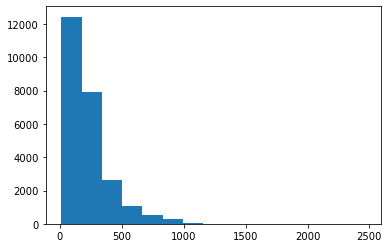

In [21]:
plt.hist(list(map(lambda x:len(x.split()), inputs)), 15)

In [68]:
def clean_text(text):
    table = str.maketrans('', '', string.punctuation)
    html = re.compile("<[^>]*>")
    
    def clean(row):
        row = html.sub('', row).lower().split()
        row = map(lambda x:x.translate(table), row)
        return ' '.join(row)
    
    cleaned = list(map(clean, text))
    return cleaned

In [70]:
clean_inputs = clean_text(inputs)

### Séparation des sets

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    clean_inputs, labels, test_size = .2, random_state=42069)

### Mise en forme
**Nombre de mots par entrées**  

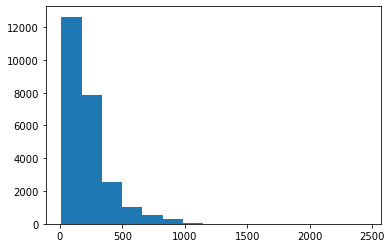

In [139]:
plt.hist(list(map(lambda x:len(x.split()), clean_inputs)), 15)
MAX_LEN = 250

Pour la tokenization, la classe `Tokenizer` de keras sera utilisé pour être rapide.  
Elle effectue une tokenisation basique comme vu en TD. Mais on utilisera le tfidf comme vectorisation du texte.

In [74]:
def get_vocab(text):
    vocab = Counter()
    for row in text:
        tokens = row.split()
        vocab.update(tokens)
    return vocab

In [85]:
vocab = get_vocab(X_train)

In [141]:
tokenizer = Tokenizer(num_words = len(vocab))
tokenizer.fit_on_texts(X_train)

In [76]:
len(vocab)

142617

In [136]:
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

In [137]:
X_train_tok = pad_sequences(X_train_tok, maxlen = MAX_LEN, padding = 'post')
X_test_tok = pad_sequences(X_test_tok, maxlen = MAX_LEN, padding = 'post')

## Model

In [155]:
with tf.device('/gpu:0'):
    inp = layers.Input(shape = (MAX_LEN,))
    emb = layers.Embedding(input_dim = len(vocab), output_dim = 64, input_length = MAX_LEN)(inp)
    rec = layers.Bidirectional(layers.LSTM(64))(emb)
    full = layers.Dense(64, activation='relu')(rec)
    out = layers.Dense(1, activation='sigmoid')(full)
    model1 = Model(inputs=inp, outputs=out)
model1.summary()

Model: "functional_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 6210)]            0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 6210, 64)          7949056   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 8,023,425
Trainable params: 8,023,425
Non-trainable params: 0
_________________________________________________________________


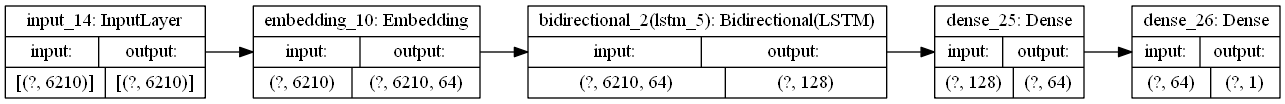

In [156]:
tf.keras.utils.plot_model(
    model1, show_shapes=True,
    show_layer_names=True,
    rankdir='LR'
)

In [157]:
model1.compile(
    loss=binary_crossentropy,
    optimizer='adam',
    metrics=['acc']
)

with tf.device('/gpu:0'):
    history = model1.fit(
        X_train_tok, y_train,
        batch_size=1024,
        epochs=10,
        verbose=1,
        validation_split = .2,
        use_multiprocessing = True
    )

Epoch 1/10


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[1024,6210,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator gpu_host_bfc
	 [[node functional_22/embedding_10/embedding_lookup (defined at <ipython-input-157-39348a9ad881>:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[functional_22/embedding_10/embedding_lookup/_22]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[1024,6210,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator gpu_host_bfc
	 [[node functional_22/embedding_10/embedding_lookup (defined at <ipython-input-157-39348a9ad881>:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_39338]

Errors may have originated from an input operation.
Input Source operations connected to node functional_22/embedding_10/embedding_lookup:
 functional_22/embedding_10/embedding_lookup/37112 (defined at D:\Programmes\Anaconda3\envs\textmining\lib\contextlib.py:112)

Input Source operations connected to node functional_22/embedding_10/embedding_lookup:
 functional_22/embedding_10/embedding_lookup/37112 (defined at D:\Programmes\Anaconda3\envs\textmining\lib\contextlib.py:112)

Function call stack:
train_function -> train_function


# Question

In [ ]:
e_input = layers.Input(shape = (10,))
e_embed = layers.Embedding(input_dim = len(ch2int_fr)+1, output_dim = 128, input_length = 10)(e_input)
e_lstm = layers.LSTM(512, return_sequences = True)(e_embed)
e_out, state_h, state_c = layers.LSTM(1024, return_state = True)(e_lstm)
encoder_states = [state_h, state_c]

d_input = layers.Input(shape = (1024,), dtype = tf.int32)
d_gru = layers.GRU(256, initial_state = encoder_states)(d_input)
d_out = layers.Dense(620, activation = 'softmax')(d_gru)

model2 = Model(inputs=[e_input, d_input], outputs=d_out)